# Sky Matching 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

When a user decided to mosaic several images it can be difficult to decide how to relate the background of one image to the others. AstroDrizzle has the ability to compute and then either subtract or equalize the background in input images in order to match the sky between those images. The function allows users to select the algorithm for the sky subtraction using the `skymethod` parameter. 

There are four methods available in sky matching: 'localmin', 'match', 'globalmin', 'globalmin+match'.

By applying `drizzlepac.sky.sky()`, or by applying the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files. 

The **recommended** use for images with sparse fields that have few astronomical sources is `skymethod = localmin` and for images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = match` is recommended.

For more information on the specifics of this function please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky).

Below, each of the four methods will be demonstrated using a single example dataset, and differences between the methods will be highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
import glob
import os
import shutil
from shutil import copyfile

from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd

import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import tweakback
from stwcs import updatewcs 

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


## 1. Retrieve Observations using Astroquery

WFC3/IR observations of the Horsehead Nebula obtained in HST proposal 12812 (PI: Levay) will be used for this demonstration. The images have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding.

The alignment specifics for this example are based on the example found [here](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt). We will provide explanation about the process as we go. 

The code used to retrieve the data from astroquery is below.

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(proposal_id='12812', filters=["F160W"], project='HST')
obs_table.show_in_notebook()

# Figure out the downloadable products:
dataProductsByObservation = Observations.get_product_list(obs_table)
dataProductsByObservation.show_in_notebook()

# Download the flc.fits files: 
obsids = obs_table['obsid']

# Download the data - uncomment to download: 
Observations.download_products(obsids, mrp_only=False, productSubGroupDescription=['FLT', 'DRZ'])

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/ibxl56030/ibxl56030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl56huq/ibxl56huq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl56i2q/ibxl56i2q_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58030/ibxl58030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58sqq/ibxl58sqq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl58svq/ibxl58svq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl54030/ibxl54030_drz.fits,COMPLETE,None,None
./mastDownload/HST/ibxl54bgq/ibxl54bgq_flt.fits,COMPLETE,None,None
./mastDownload/HST/ibxl54blq/ibxl54blq_flt.fits,COMPLETE,None,None


### Move files to the local directory 

In [3]:
flt_files = glob.glob('mastDownload/*/*/*flt.fits')

for file in flt_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_flt.fits"
    copyfile(file, dst)

drz_files = glob.glob('mastDownload/*/*/*drz.fits')

for file in drz_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_drz.fits"
    copyfile(file, dst)

### Inspect the image headers

In [4]:
collect_flt = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
flt_table = collect_flt.summary
flt_table['exptime'].format = '7.1f'
flt_table['postarg1'].format = '7.2f'
flt_table['postarg2'].format = '7.2f'
flt_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str18,str9,str2,str5,float64,float64,float64
ibxl50clq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-113.11
ibxl50cqq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-105.91
ibxl51eoq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-113.11
ibxl51etq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-105.91
ibxl52k0q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-113.11
ibxl52k5q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-105.91
ibxl53kxq_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,-3.60
ibxl53l9q_flt.fits,IBXL53030,IR,F160W,702.9,-123.74,3.60
ibxl54bgq_flt.fits,IBXL54030,IR,F160W,702.9,0.00,-3.60


In [5]:
collect_drz = ImageFileCollection('./', glob_include="*drz.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime"])
    
drz_table = collect_drz.summary
drz_table['exptime'].format = '7.1f'
drz_table

file,asn_id,detector,filter,exptime
str18,str9,str2,str5,float64
ibxl50030_drz.fits,IBXL50030,IR,F160W,1405.9
ibxl51030_drz.fits,IBXL51030,IR,F160W,1405.9
ibxl52030_drz.fits,IBXL52030,IR,F160W,1405.9
ibxl53030_drz.fits,IBXL53030,IR,F160W,1405.9
ibxl54030_drz.fits,IBXL54030,IR,F160W,1405.9
ibxl55030_drz.fits,IBXL55030,IR,F160W,1405.9
ibxl56030_drz.fits,IBXL56030,IR,F160W,1405.9
ibxl57030_drz.fits,IBXL57030,IR,F160W,1405.9
ibxl58030_drz.fits,IBXL58030,IR,F160W,1405.9


## 2. Align the visit-level drizzled data

Exposures obtained within a single HST visit tend to be aligned very well since they use the same guide stars. Thus, we will use TweakReg to align the DRZ files and then use TweakBack to propagate those solutions back to the FLT image headers prior to combining with AstroDrizzle. Making use of the parameter `expand_refcat`, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. For this dataset, we obtain the best results when we tell TweakReg to align the DRZ files in a specific order, and this is achieved by giving a list of files as input. More details on alignment of HST mosaics can be found in the notebook 'mosaics.ipynb' in this repository.
    
    drz.list
    ibxl54030_drz.fits	<-- Note that tile 54 is the reference and is listed first
    ibxl51030_drz.fits  
    ibxl53030_drz.fits
    ibxl55030_drz.fits
    ibxl57030_drz.fits
    ibxl50030_drz.fits
    ibxl52030_drz.fits
    ibxl56030_drz.fits
    ibxl58030_drz.fits
      ____ ____ ____
     |    |    |    |    <-- The 4 tiles with the most overlap are aligned first
     |    | 55 |    |
     |____|____|____|
     |    |    |    |
     | 57 | 54 | 51 |
     |____|____|____|
     |    |    |    |
     |    | 53 |    |
     |____|____|____|
   
      ____ ____ ____
     |    |    |    |    <-- Then the corner tiles are added 
     | 58 |    | 52 |
     |____|____|____|
     |    |    |    |
     |    |    |    |
     |____|____|____|
     |    |    |    |
     | 56 |    | 50 |
     |____|____|____|

This allows TweakReg to start with the tiles with the most overlap first and then build upon that, expanding the reference catalog as each new tile is aligned. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.7(18-April-2018) started at: 05:10:24.825 (08/01/2019) 


TweakReg Version 1.4.7(18-April-2018) started at: 05:10:24.825 (08/01/2019) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.util:3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


INFO:drizzlepac.util:numpy Version -> 1.15.4 


numpy Version -> 1.15.4 


INFO:drizzlepac.util:astropy Version -> 3.1.1 


astropy Version -> 3.1.1 


INFO:drizzlepac.util:stwcs Version -> 1.4.2 


stwcs Version -> 1.4.2 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	exclusions :	


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakutils:ibxl54030_drz.fits


ibxl54030_drz.fits


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibxl54030_drz.fits


    ibxl54030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl51030_drz.fits


    ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl53030_drz.fits


    ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl55030_drz.fits


    ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl57030_drz.fits


    ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl50030_drz.fits


    ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl52030_drz.fits


    ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl56030_drz.fits


    ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl58030_drz.fits


    ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:


INFO:drizzlepac.tweakreg:	clean :	False


INFO:drizzlepac.tweakreg:	computesig :	True


INFO:drizzlepac.tweakreg:	conv_width :	4.5


INFO:drizzlepac.tweakreg:	dqbits :	


INFO:drizzlepac.tweakreg:	enforce_user_order :	True


INFO:drizzlepac.tweakreg:	expand_refcat :	True


INFO:drizzlepac.tweakreg:	fluxmax :	None


INFO:drizzlepac.tweakreg:	fluxmin :	None


INFO:drizzlepac.tweakreg:	input :	@drz.list


INFO:drizzlepac.tweakreg:	interactive :	False


INFO:drizzlepac.tweakreg:	nsigma :	1.5


INFO:drizzlepac.tweakreg:	peakmax :	None


INFO:drizzlepac.tweakreg:	peakmin :	1


INFO:drizzlepac.tweakreg:	ratio :	1.0


INFO:drizzlepac.tweakreg:	refimage :	


INFO:drizzlepac.tweakreg:	roundhi :	1.0


INFO:drizzlepac.tweakreg:	roundlo :	-1.0


INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log


INFO:drizzlepac.tweakreg:	sharphi :	1.0


INFO:drizzlepac.tweakreg:	sharplo :	0.2


INFO:drizzlepac.tweakreg:	skysigma :	0.0


INFO:drizzlepac.tweakreg:	theta :	0.0


INFO:drizzlepac.tweakreg:	threshold :	10


INFO:drizzlepac.tweakreg:	updatehdr :	True


INFO:drizzlepac.tweakreg:	updatewcs :	False


INFO:drizzlepac.tweakreg:	use_sharp_round :	False


INFO:drizzlepac.tweakreg:	verbose :	False


INFO:drizzlepac.tweakreg:	writecat :	True


INFO:drizzlepac.tweakreg:	xyunits :	pixels


INFO:drizzlepac.tweakreg:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl54030_drz.fits':


===  Source finding for image 'ibxl54030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.257 (08/01/2019)


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.257 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.183269


  tdata=np.where(convdata > threshold, convdata, 0)



INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:25.357 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 98 objects.


     Found 98 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl54030_drz.fits': 98


===  FINAL number of objects in image 'ibxl54030_drz.fits': 98


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl51030_drz.fits':


===  Source finding for image 'ibxl51030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.500 (08/01/2019)


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.500 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.119178


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:25.586 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 154 objects.


     Found 154 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl51030_drz.fits': 154


===  FINAL number of objects in image 'ibxl51030_drz.fits': 154


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl53030_drz.fits':


===  Source finding for image 'ibxl53030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.770 (08/01/2019)


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.770 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.070589


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:25.871 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 130 objects.


     Found 130 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl53030_drz.fits': 130


===  FINAL number of objects in image 'ibxl53030_drz.fits': 130


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl55030_drz.fits':


===  Source finding for image 'ibxl55030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.993 (08/01/2019)


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 05:10:25.993 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.058994


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:26.098 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 202 objects.


     Found 202 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl55030_drz.fits': 202


===  FINAL number of objects in image 'ibxl55030_drz.fits': 202


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl57030_drz.fits':


===  Source finding for image 'ibxl57030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.234 (08/01/2019)


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.234 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.061287


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:26.329 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 268 objects.


     Found 268 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl57030_drz.fits': 268


===  FINAL number of objects in image 'ibxl57030_drz.fits': 268


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl50030_drz.fits':


===  Source finding for image 'ibxl50030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.454 (08/01/2019)


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.454 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.252190


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:26.556 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 126 objects.


     Found 126 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl50030_drz.fits': 126


===  FINAL number of objects in image 'ibxl50030_drz.fits': 126


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl52030_drz.fits':


===  Source finding for image 'ibxl52030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.685 (08/01/2019)


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.685 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.016099


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:26.80 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 237 objects.


     Found 237 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl52030_drz.fits': 237


===  FINAL number of objects in image 'ibxl52030_drz.fits': 237


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl56030_drz.fits':


===  Source finding for image 'ibxl56030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.938 (08/01/2019)


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 05:10:26.938 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.200698


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:27.025 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 142 objects.


     Found 142 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl56030_drz.fits': 142


===  FINAL number of objects in image 'ibxl56030_drz.fits': 142


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl58030_drz.fits':


===  Source finding for image 'ibxl58030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 05:10:27.162 (08/01/2019)


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 05:10:27.162 (08/01/2019)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 0.010125


INFO:drizzlepac.catalogs:###Source finding finished at: 05:10:27.303 (08/01/2019)


INFO:drizzlepac.catalogs:     Found 428 objects.


     Found 428 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl58030_drz.fits': 428


===  FINAL number of objects in image 'ibxl58030_drz.fits': 428


INFO:drizzlepac.imgclasses:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibxl54030_drz.fits" to X,Y positions in reference WCS...


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibxl54030_drz.fits'


derived from 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	searchrad :	3.0


INFO:drizzlepac.tweakreg:	searchunits :	arcseconds


INFO:drizzlepac.tweakreg:	see2dplot :	True


INFO:drizzlepac.tweakreg:	separation :	0.5


INFO:drizzlepac.tweakreg:	tolerance :	1.0


INFO:drizzlepac.tweakreg:	use2dhist :	True


INFO:drizzlepac.tweakreg:	xoffset :	0.0


INFO:drizzlepac.tweakreg:	yoffset :	0.0


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:


INFO:drizzlepac.tweakreg:	fitgeometry :	rscale


INFO:drizzlepac.tweakreg:	labelsize :	8


INFO:drizzlepac.tweakreg:	minobj :	5


INFO:drizzlepac.tweakreg:	nclip :	3


INFO:drizzlepac.tweakreg:	residplot :	both


INFO:drizzlepac.tweakreg:	sigma :	3.0


INFO:drizzlepac.tweakreg:	ylimit :	0.5


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:


INFO:drizzlepac.tweakreg:	outshifts :	shift4_drc.txt


INFO:drizzlepac.tweakreg:	outwcs :	shifts_wcs.fits


INFO:drizzlepac.tweakreg:	shiftfile :	True


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl51030_drz.fits


Performing fit for: ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.6418123436685583 -0.3293123436685583


Found initial X and Y shifts of  -0.6418123436685583 -0.3293123436685583


INFO:drizzlepac.tweakutils:    with significance of  332.55375505322445 and  11.0  matches


    with significance of  332.55375505322445 and  11.0  matches


INFO:drizzlepac.imgclasses:Found 15 matches for ibxl51030_drz.fits...


Found 15 matches for ibxl51030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl51030_drz.fits : 


Computed  rscale  fit for  ibxl51030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.2993  YSH: -0.3612    ROT: 0.02169090132    SCALE: 1.000313


XSH: -0.2993  YSH: -0.3612    ROT: 0.02169090132    SCALE: 1.000313


INFO:drizzlepac.imgclasses:XRMS: 0.13    YRMS: 0.15


XRMS: 0.13    YRMS: 0.15


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.8e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


RMS_RA: 5.8e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  14  objects.


Final solution based on  14  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl51030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl51030_drz_catalog_fit.match


wrote XY data to:  ibxl51030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  14


Total # points:  14


INFO:drizzlepac.tweakutils:# of points after clipping:  14


# of points after clipping:  14


INFO:drizzlepac.tweakutils:Total # points:  14


Total # points:  14


INFO:drizzlepac.tweakutils:# of points after clipping:  14


# of points after clipping:  14


INFO:drizzlepac.imgclasses:Adding 139 new sources to the reference catalog for a total of 237 sources.


Adding 139 new sources to the reference catalog for a total of 237 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl51030_drz.fits


Initializing new WCSCORR table for  ibxl51030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl51030_drz.fits...


....Updating header for ibxl51030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl51030_drz.fits['SCI',1]


Processing ibxl51030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl51030_drz.fits[1]


Updating header for ibxl51030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4704069446310476e-05 7.998411115509849e-06


CD_11  CD_12: 3.4704069446310476e-05 7.998411115509849e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 7.99841111820866e-06 -3.4704069438608114e-05


CD_21  CD_22: 7.99841111820866e-06 -3.4704069438608114e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.2616469581193 -2.482874424795535


CRVAL    : 85.2616469581193 -2.482874424795535


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 167.021404602313


ORIENTAT : 167.021404602313


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.280701232557448 -0.1695901214463369


Found initial X and Y shifts of  -4.280701232557448 -0.1695901214463369


INFO:drizzlepac.tweakutils:    with significance of  209.14110069520052 and  5.0  matches


    with significance of  209.14110069520052 and  5.0  matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl53030_drz.fits...


Found 6 matches for ibxl53030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl53030_drz.fits : 


Computed  rscale  fit for  ibxl53030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -4.2058  YSH: 0.3232    ROT: 359.9784605    SCALE: 1.000371


XSH: -4.2058  YSH: 0.3232    ROT: 359.9784605    SCALE: 1.000371


INFO:drizzlepac.imgclasses:XRMS: 0.11    YRMS: 0.17


XRMS: 0.11    YRMS: 0.17


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.2e-06 (deg)   RMS_DEC: 5e-06 (deg)


RMS_RA: 5.2e-06 (deg)   RMS_DEC: 5e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl53030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl53030_drz_catalog_fit.match


wrote XY data to:  ibxl53030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  6


Total # points:  6


INFO:drizzlepac.tweakutils:# of points after clipping:  6


# of points after clipping:  6


INFO:drizzlepac.tweakutils:Total # points:  6


Total # points:  6


INFO:drizzlepac.tweakutils:# of points after clipping:  6


# of points after clipping:  6


INFO:drizzlepac.imgclasses:Adding 124 new sources to the reference catalog for a total of 361 sources.


Adding 124 new sources to the reference catalog for a total of 361 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl53030_drz.fits


Initializing new WCSCORR table for  ibxl53030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl53030_drz.fits...


....Updating header for ibxl53030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl53030_drz.fits['SCI',1]


Processing ibxl53030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl53030_drz.fits[1]


Updating header for ibxl53030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.455051606446498e-05 8.629104311595514e-06


CD_11  CD_12: 3.455051606446498e-05 8.629104311595514e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.629104300644051e-06 -3.4550516097193484e-05


CD_21  CD_22: 8.629104300644051e-06 -3.4550516097193484e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.28809146208636 -2.444703924303197


CRVAL    : 85.28809146208636 -2.444703924303197


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1282500028610226


Plate Scale : 0.1282500028610226


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 165.97706242768078


ORIENTAT : 165.97706242768078


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl55030_drz.fits


Performing fit for: ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.14181234366855833 -0.3084790103352262


Found initial X and Y shifts of  -0.14181234366855833 -0.3084790103352262


INFO:drizzlepac.tweakutils:    with significance of  249.4153162899183 and  7.0  matches


    with significance of  249.4153162899183 and  7.0  matches


INFO:drizzlepac.imgclasses:Found 8 matches for ibxl55030_drz.fits...


Found 8 matches for ibxl55030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl55030_drz.fits : 


Computed  rscale  fit for  ibxl55030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2564  YSH: -0.1030    ROT: 359.9896514    SCALE: 0.999885


XSH: 0.2564  YSH: -0.1030    ROT: 359.9896514    SCALE: 0.999885


INFO:drizzlepac.imgclasses:XRMS: 0.092    YRMS: 0.23


XRMS: 0.092    YRMS: 0.23


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5e-06 (deg)   RMS_DEC: 7.3e-06 (deg)


RMS_RA: 5e-06 (deg)   RMS_DEC: 7.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  8  objects.


Final solution based on  8  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl55030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl55030_drz_catalog_fit.match


wrote XY data to:  ibxl55030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  8


Total # points:  8


INFO:drizzlepac.tweakutils:# of points after clipping:  8


# of points after clipping:  8


INFO:drizzlepac.tweakutils:Total # points:  8


Total # points:  8


INFO:drizzlepac.tweakutils:# of points after clipping:  8


# of points after clipping:  8


INFO:drizzlepac.imgclasses:Adding 194 new sources to the reference catalog for a total of 555 sources.


Adding 194 new sources to the reference catalog for a total of 555 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl55030_drz.fits


Initializing new WCSCORR table for  ibxl55030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl55030_drz.fits...


....Updating header for ibxl55030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl55030_drz.fits['SCI',1]


Processing ibxl55030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl55030_drz.fits[1]


Updating header for ibxl55030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4714669673306934e-05 8.020213780289394e-06


CD_11  CD_12: 3.4714669673306934e-05 8.020213780289394e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.020213792045647e-06 -3.471466968218008e-05


CD_21  CD_22: 8.020213792045647e-06 -3.471466968218008e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.2211379800382 -2.4612093648170354


CRVAL    : 85.2211379800382 -2.4612093648170354


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1282500028610226


Plate Scale : 0.1282500028610226


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.9910674283944


ORIENTAT : 166.9910674283944


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl57030_drz.fits


Performing fit for: ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -3.9251456770018898 -1.658479010335224


Found initial X and Y shifts of  -3.9251456770018898 -1.658479010335224


INFO:drizzlepac.tweakutils:    with significance of  246.47515087732475 and  7.0  matches


    with significance of  246.47515087732475 and  7.0  matches


INFO:drizzlepac.imgclasses:Found 12 matches for ibxl57030_drz.fits...


Found 12 matches for ibxl57030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl57030_drz.fits : 


Computed  rscale  fit for  ibxl57030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -3.7893  YSH: -1.3918    ROT: 359.9776196    SCALE: 1.000054


XSH: -3.7893  YSH: -1.3918    ROT: 359.9776196    SCALE: 1.000054


INFO:drizzlepac.imgclasses:XRMS: 0.14    YRMS: 0.2


XRMS: 0.14    YRMS: 0.2


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.4e-06 (deg)   RMS_DEC: 5.8e-06 (deg)


RMS_RA: 6.4e-06 (deg)   RMS_DEC: 5.8e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  12  objects.


Final solution based on  12  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl57030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl57030_drz_catalog_fit.match


wrote XY data to:  ibxl57030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  12


Total # points:  12


INFO:drizzlepac.tweakutils:# of points after clipping:  12


# of points after clipping:  12


INFO:drizzlepac.tweakutils:Total # points:  12


Total # points:  12


INFO:drizzlepac.tweakutils:# of points after clipping:  12


# of points after clipping:  12


INFO:drizzlepac.imgclasses:Adding 256 new sources to the reference catalog for a total of 811 sources.


Adding 256 new sources to the reference catalog for a total of 811 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl57030_drz.fits


Initializing new WCSCORR table for  ibxl57030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl57030_drz.fits...


....Updating header for ibxl57030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl57030_drz.fits['SCI',1]


Processing ibxl57030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl57030_drz.fits[1]


Updating header for ibxl57030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.470697460500454e-05 8.026823445667009e-06


CD_11  CD_12: 3.470697460500454e-05 8.026823445667009e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.0268234039996e-06 -3.4706974603844374e-05


CD_21  CD_22: 8.0268234039996e-06 -3.4706974603844374e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.24773669374014 -2.423693003254841


CRVAL    : 85.24773669374014 -2.423693003254841


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.97792332923314


ORIENTAT : 166.97792332923314


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl50030_drz.fits


Performing fit for: ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:stsci.imagestats:! WARNING: Clipped data falls within 1 histogram bin


! WARNING: Clipped data falls within 1 histogram bin


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -1.3418123436685576 -1.291812343668557


Found initial X and Y shifts of  -1.3418123436685576 -1.291812343668557


INFO:drizzlepac.tweakutils:    with significance of  309.8386676965934 and  11.0  matches


    with significance of  309.8386676965934 and  11.0  matches


INFO:drizzlepac.imgclasses:Found 15 matches for ibxl50030_drz.fits...


Found 15 matches for ibxl50030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl50030_drz.fits : 


Computed  rscale  fit for  ibxl50030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.7626  YSH: 0.3315    ROT: 0.03749598082    SCALE: 0.999318


XSH: -0.7626  YSH: 0.3315    ROT: 0.03749598082    SCALE: 0.999318


INFO:drizzlepac.imgclasses:XRMS: 0.088    YRMS: 0.1


XRMS: 0.088    YRMS: 0.1


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 3.9e-06 (deg)   RMS_DEC: 2.9e-06 (deg)


RMS_RA: 3.9e-06 (deg)   RMS_DEC: 2.9e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  15  objects.


Final solution based on  15  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl50030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl50030_drz_catalog_fit.match


wrote XY data to:  ibxl50030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  15


Total # points:  15


INFO:drizzlepac.tweakutils:# of points after clipping:  15


# of points after clipping:  15


INFO:drizzlepac.tweakutils:Total # points:  15


Total # points:  15


INFO:drizzlepac.tweakutils:# of points after clipping:  15


# of points after clipping:  15


INFO:drizzlepac.imgclasses:Adding 111 new sources to the reference catalog for a total of 922 sources.


Adding 111 new sources to the reference catalog for a total of 922 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl50030_drz.fits


Initializing new WCSCORR table for  ibxl50030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl50030_drz.fits...


....Updating header for ibxl50030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl50030_drz.fits['SCI',1]


Processing ibxl50030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl50030_drz.fits[1]


Updating header for ibxl50030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.521390716676623e-05 5.554779065522171e-06


CD_11  CD_12: 3.521390716676623e-05 5.554779065522171e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 5.554779091051484e-06 -3.521390717302552e-05


CD_21  CD_22: 5.554779091051484e-06 -3.521390717302552e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.29352795972844 -2.4777496507550865


CRVAL    : 85.29352795972844 -2.4777496507550865


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 171.03580565504606


ORIENTAT : 171.03580565504606


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl52030_drz.fits


Performing fit for: ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.199504651360865 -2.6610431128993284


Found initial X and Y shifts of  -4.199504651360865 -2.6610431128993284


INFO:drizzlepac.tweakutils:    with significance of  293.07296822784997 and  9.0  matches


    with significance of  293.07296822784997 and  9.0  matches


INFO:drizzlepac.imgclasses:Found 20 matches for ibxl52030_drz.fits...


Found 20 matches for ibxl52030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl52030_drz.fits : 


Computed  rscale  fit for  ibxl52030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -3.9448  YSH: -2.9939    ROT: 0.0328068772    SCALE: 1.000192


XSH: -3.9448  YSH: -2.9939    ROT: 0.0328068772    SCALE: 1.000192


INFO:drizzlepac.imgclasses:XRMS: 0.14    YRMS: 0.22


XRMS: 0.14    YRMS: 0.22


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.8e-06 (deg)   RMS_DEC: 6.6e-06 (deg)


RMS_RA: 6.8e-06 (deg)   RMS_DEC: 6.6e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  20  objects.


Final solution based on  20  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl52030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl52030_drz_catalog_fit.match


wrote XY data to:  ibxl52030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.tweakutils:Total # points:  20


Total # points:  20


INFO:drizzlepac.tweakutils:# of points after clipping:  20


# of points after clipping:  20


INFO:drizzlepac.imgclasses:Adding 217 new sources to the reference catalog for a total of 1139 sources.


Adding 217 new sources to the reference catalog for a total of 1139 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl52030_drz.fits


Initializing new WCSCORR table for  ibxl52030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl52030_drz.fits...


....Updating header for ibxl52030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl52030_drz.fits['SCI',1]


Processing ibxl52030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl52030_drz.fits[1]


Updating header for ibxl52030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.471002179904183e-05 7.991804231789764e-06


CD_11  CD_12: 3.471002179904183e-05 7.991804231789764e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 7.991804267055361e-06 -3.471002168790647e-05


CD_21  CD_22: 7.991804267055361e-06 -3.471002168790647e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.22831353382003 -2.4908470765079245


CRVAL    : 85.22831353382003 -2.4908470765079245


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102256


Plate Scale : 0.12825000286102256


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 167.03391139348608


ORIENTAT : 167.03391139348608


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl56030_drz.fits


Performing fit for: ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -4.456328472700815 -1.0692316985072665


Found initial X and Y shifts of  -4.456328472700815 -1.0692316985072665


INFO:drizzlepac.tweakutils:    with significance of  339.587985653203 and  13.0  matches


    with significance of  339.587985653203 and  13.0  matches


INFO:drizzlepac.imgclasses:Found 21 matches for ibxl56030_drz.fits...


Found 21 matches for ibxl56030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl56030_drz.fits : 


Computed  rscale  fit for  ibxl56030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -4.4839  YSH: -1.0790    ROT: 359.9593497    SCALE: 0.999805


XSH: -4.4839  YSH: -1.0790    ROT: 359.9593497    SCALE: 0.999805


INFO:drizzlepac.imgclasses:XRMS: 0.12    YRMS: 0.14


XRMS: 0.12    YRMS: 0.14


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 5.2e-06 (deg)   RMS_DEC: 3.8e-06 (deg)


RMS_RA: 5.2e-06 (deg)   RMS_DEC: 3.8e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  19  objects.


Final solution based on  19  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl56030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl56030_drz_catalog_fit.match


wrote XY data to:  ibxl56030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  19


Total # points:  19


INFO:drizzlepac.tweakutils:# of points after clipping:  19


# of points after clipping:  19


INFO:drizzlepac.tweakutils:Total # points:  19


Total # points:  19


INFO:drizzlepac.tweakutils:# of points after clipping:  19


# of points after clipping:  19


INFO:drizzlepac.imgclasses:Adding 121 new sources to the reference catalog for a total of 1260 sources.


Adding 121 new sources to the reference catalog for a total of 1260 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl56030_drz.fits


Initializing new WCSCORR table for  ibxl56030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl56030_drz.fits...


....Updating header for ibxl56030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl56030_drz.fits['SCI',1]


Processing ibxl56030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl56030_drz.fits[1]


Updating header for ibxl56030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.406741438130981e-05 1.0442535667821051e-05


CD_11  CD_12: 3.406741438130981e-05 1.0442535667821051e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.044253560973041e-05 -3.406741443355216e-05


CD_21  CD_22: 1.044253560973041e-05 -3.406741443355216e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.27855589666656 -2.413955941920053


CRVAL    : 85.27855589666656 -2.413955941920053


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 162.95835550270613


ORIENTAT : 162.95835550270613


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl58030_drz.fits


Performing fit for: ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.3048558219294293 -0.37007321323377695


Found initial X and Y shifts of  -0.3048558219294293 -0.37007321323377695


INFO:drizzlepac.tweakutils:    with significance of  361.49688795340967 and  15.0  matches


    with significance of  361.49688795340967 and  15.0  matches


INFO:drizzlepac.imgclasses:Found 33 matches for ibxl58030_drz.fits...


Found 33 matches for ibxl58030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.linearfit:Performing "rscale" fit


INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl58030_drz.fits : 


Computed  rscale  fit for  ibxl58030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.4163  YSH: 0.0935    ROT: 359.9810933    SCALE: 1.000133


XSH: 0.4163  YSH: 0.0935    ROT: 359.9810933    SCALE: 1.000133


INFO:drizzlepac.imgclasses:XRMS: 0.11    YRMS: 0.076


XRMS: 0.11    YRMS: 0.076


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4.5e-06 (deg)   RMS_DEC: 1.7e-06 (deg)


RMS_RA: 4.5e-06 (deg)   RMS_DEC: 1.7e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  29  objects.


Final solution based on  29  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl58030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl58030_drz_catalog_fit.match


wrote XY data to:  ibxl58030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points:  29


Total # points:  29


INFO:drizzlepac.tweakutils:# of points after clipping:  29


# of points after clipping:  29


INFO:drizzlepac.tweakutils:Total # points:  29


Total # points:  29


INFO:drizzlepac.tweakutils:# of points after clipping:  29


# of points after clipping:  29


INFO:drizzlepac.imgclasses:Adding 395 new sources to the reference catalog for a total of 1655 sources.


Adding 395 new sources to the reference catalog for a total of 1655 sources.


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl58030_drz.fits


Initializing new WCSCORR table for  ibxl58030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for ibxl58030_drz.fits...


....Updating header for ibxl58030_drz.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl58030_drz.fits['SCI',1]


Processing ibxl58030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.updatehdr:Updating header for ibxl58030_drz.fits[1]


Updating header for ibxl58030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of


INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.4704896582785776e-05 8.023226884654208e-06


CD_11  CD_12: 3.4704896582785776e-05 8.023226884654208e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.023226892323844e-06 -3.470489656767818e-05


CD_21  CD_22: 8.023226892323844e-06 -3.470489656767818e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.21411150174491 -2.4316128925626592


CRVAL    : 85.21411150174491 -2.4316128925626592


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102273


Plate Scale : 0.12825000286102273


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.98280651848978


ORIENTAT : 166.98280651848978


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  ibxl54030_drz.fits


Initializing new WCSCORR table for  ibxl54030_drz.fits


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imgclasses:    Saving Primary WCS to alternate WCS: " "


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.tweakutils:Writing out shiftfile : shift4_drc.txt


Writing out shiftfile : shift4_drc.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


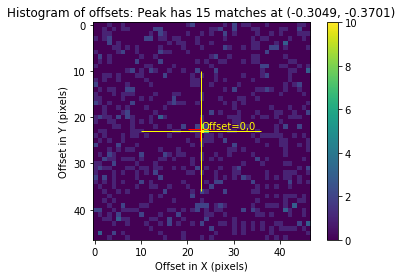

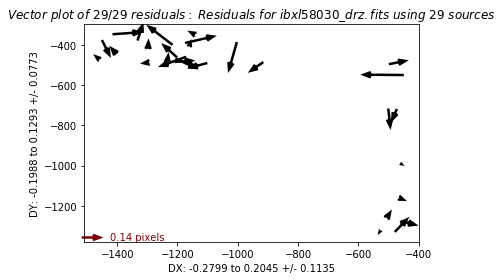

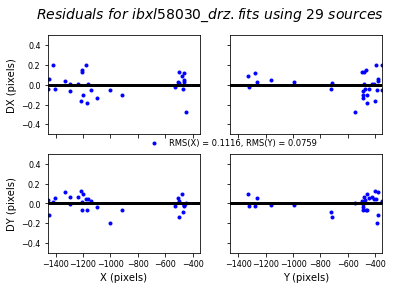

In [6]:
tweakreg.TweakReg('@drz.list', 
                  imagefindcfg={'threshold': 10, 'conv_width': 4.5, 'peakmin': 1}, 
                  minobj=5, 
                  shiftfile=True, 
                  expand_refcat=True, 
                  enforce_user_order=True, 
                  outshifts='shift4_drc.txt',
                  searchrad=3.0,
                  ylimit=0.5, 
                  updatehdr=True, 
                  interactive=False)

Tweakback is then run on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [7]:
drz_files = glob.glob('i*_drz.fits')

for f in drz_files:
    tweakback.tweakback(f, verbose=True)

Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:35.902 (08/01/2019)


....Updating header for ibxl50clq_flt.fits...


Processing ibxl50clq_flt.fits['SCI',1]

Updating header for ibxl50clq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.7170236038191656e-05 5.453357588944277e-06
CD_21  CD_22: 5.98115961064146e-06 -3.318194921499996e-05
CRVAL    : 85.2935399918238 -2.478452032415801
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544167579742653
ORIENTAT : 170.66703490218052
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl50cqq_flt.fits...


Processing ibxl50cqq_flt.fits['SCI',1]

Updating header for ibxl50cqq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.7169086272468495e-05 5.453188937372901e-06
CD_21  CD_22: 5.980974647979729e-06 -3.318092282037506e-05
CRVAL    : 85.29321638220857 -2.476476954124375
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543748627794666
ORIENTAT : 170.66703484598455
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:36.269 (08/01/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl51eoq_flt.fits...


Processing ibxl51eoq_flt.fits['SCI',1]

Updating header for ibxl51eoq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.662427447587403e-05 7.755321779588499e-06
CD_21  CD_22: 8.560245487247927e-06 -3.268659776121534e-05
CRVAL    : 85.26170840683648 -2.4835737011863137
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354432950174527
ORIENTAT : 166.65263374365233
WCSNAME  :  TWEAK

....Updating header for ibxl51etq_flt.fits...


Processing ibxl51etq_flt.fits['SCI',1]

Updating header for ibxl51etq_flt.fits[1]


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


WCS Keywords

CD_11  CD_12: 3.662317504858981e-05 7.755088983746942e-06
CD_21  CD_22: 8.559988552635132e-06 -3.2685616500753825e-05
CRVAL    : 85.26124764824554 -2.4816280406075277
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354392291537339
ORIENTAT : 166.65263370879353
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:36.639 (08/01/2019)


....Updating header for ibxl52k0q_flt.fits...


Processing ibxl52k0q_flt.fits['SCI',1]

Updating header for ibxl52k0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6630544719522276e-05 7.749117929675155e-06
CD_21  CD_22: 8.553278766459404e-06 -3.2692218954160844e-05
CRVAL    : 85.2283748222252 -2.4915464440673842
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354431563883509
ORIENTAT : 166.66514054600682
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl52k5q_flt.fits...


Processing ibxl52k5q_flt.fits['SCI',1]

Updating header for ibxl52k5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6629460380694455e-05 7.748888574217072e-06
CD_21  CD_22: 8.553025614227174e-06 -3.2691251186757594e-05
CRVAL    : 85.22791443186367 -2.489600446903669
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543914696758064
ORIENTAT : 166.66514048484905
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:37.008 (08/01/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl53kxq_flt.fits...


Processing ibxl53kxq_flt.fits['SCI',1]

Updating header for ibxl53kxq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.645884255669764e-05 8.34902405681571e-06
CD_21  CD_22: 9.225502916248277e-06 -3.253684860675422e-05
CRVAL    : 85.28816608519308 -2.4454021475828425
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354388057058682
ORIENTAT : 165.60829152358266
WCSNAME  :  TWEAK

....Updating header for ibxl53l9q_flt.fits...


Processing ibxl53l9q_flt.fits['SCI',1]



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Updating header for ibxl53l9q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.645965376293356e-05 8.349209804251689e-06
CD_21  CD_22: 9.225708168448508e-06 -3.2537572546847434e-05
CRVAL    : 85.28766995017178 -2.4434653122030356
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544181915540476
ORIENTAT : 165.6082915518681
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:37.379 (08/01/2019)


....Updating header for ibxl54bgq_flt.fits...


Processing ibxl54bgq_flt.fits['SCI',1]



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Updating header for ibxl54bgq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663238802537673e-05 7.76992513582699e-06
CD_21  CD_22: 8.576568132671791e-06 -3.269379585850745e-05
CRVAL    : 85.25468747676 -2.4539702712080005
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135442763841364
ORIENTAT : 166.6312406926125
WCSNAME  :  TWEAK

....Updating header for ibxl54blq_flt.fits...


Processing ibxl54blq_flt.fits['SCI',1]

Updating header for ibxl54blq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663133380473051e-05 7.769701534585331e-06
CD_21  CD_22: 8.576321308687358e-06 -3.269285499821504e-05
CRVAL    : 85.25422585692 -2.4520241731970005
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354388660218255
ORIENTAT : 166.63124069054808
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:37.730 (08/01/2019)


....Updating header for ibxl55f0q_flt.fits...


Processing ibxl55f0q_flt.fits['SCI',1]

Updating header for ibxl55f0q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663523160514224e-05 7.775916514239645e-06
CD_21  CD_22: 8.583266517234267e-06 -3.26963156886576e-05
CRVAL    : 85.22119975123817 -2.461908869850786
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544267969946444
ORIENTAT : 166.62229656688436
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl55f5q_flt.fits...


Processing ibxl55f5q_flt.fits['SCI',1]

Updating header for ibxl55f5q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.663418002508299e-05 7.775693311925848e-06
CD_21  CD_22: 8.583020148230529e-06 -3.2695377150321124e-05
CRVAL    : 85.2207377726373 -2.4599626203005527
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354387918949453
ORIENTAT : 166.62229656168805
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:38.097 (08/01/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of



....Updating header for ibxl56huq_flt.fits...


Processing ibxl56huq_flt.fits['SCI',1]

Updating header for ibxl56huq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.594262484922637e-05 1.0056548192387375e-05
CD_21  CD_22: 1.1138959325504762e-05 -3.207005317263151e-05
CRVAL    : 85.27866739548192 -2.4146497149904307
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543834954833228
ORIENTAT : 162.58958452997737
WCSNAME  :  TWEAK

....Updating header for ibxl56i2q_flt.fits...


Processing ibxl56i2q_flt.fits['SCI',1]

Updating header for ibxl56i2q_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.5943725944131994e-05 1.00568562331494e-05
CD_21  CD_22: 1.1139300544115048e-05 -3.2071035611117305e-05
CRVAL    : 85.27806953455207 -2.412740591817497
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.1354424986080716
ORIENTAT : 162.5895845835556
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:38.465 (08/01/2019)


....Updating header for ibxl57adq_flt.fits...


Processing ibxl57adq_flt.fits['SCI',1]

Updating header for ibxl57adq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.662675684195636e-05 7.782035047206854e-06
CD_21  CD_22: 8.590145082998682e-06 -3.268872558968963e-05
CRVAL    : 85.2477983508175 -2.4243922344775397
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13544147200217774
ORIENTAT : 166.60915245970682
WCSNAME  :  TWEAK


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl57aiq_flt.fits...


Processing ibxl57aiq_flt.fits['SCI',1]

Updating header for ibxl57aiq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.662560247404744e-05 7.781789772319492e-06
CD_21  CD_22: 8.589874326607366e-06 -3.2687695329832693e-05
CRVAL    : 85.24733601536394 -2.422446420014158
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543720321385494
ORIENTAT : 166.60915247011843
WCSNAME  :  TWEAK
TweakBack Version 0.4.0(14-Oct-2014) started at: 05:10:38.834 (08/01/2019)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



INFO:drizzlepac.updatehdr:    with WCS of


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.
 [astropy.wcs.wcs]
Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.




....Updating header for ibxl58sqq_flt.fits...


Processing ibxl58sqq_flt.fits['SCI',1]

Updating header for ibxl58sqq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.6624464376877846e-05 7.778606672429882e-06
CD_21  CD_22: 8.586314419034586e-06 -3.268668942593e-05
CRVAL    : 85.2141730028497 -2.4323120248506833
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.135441066385391
ORIENTAT : 166.6140356451665
WCSNAME  :  TWEAK

....Updating header for ibxl58svq_flt.fits...


Processing ibxl58svq_flt.fits['SCI',1]



INFO:drizzlepac.updatehdr:    with WCS of


Updating header for ibxl58svq_flt.fits[1]
WCS Keywords

CD_11  CD_12: 3.662327127880739e-05 7.778353270800062e-06
CD_21  CD_22: 8.586034706995289e-06 -3.26856246303436e-05
CRVAL    : 85.2137108681931 -2.4303663258244654
CRPIX    : 507.0 507.0
NAXIS    : 1014 1014
Plate Scale : 0.13543665421419215
ORIENTAT : 166.61403565705922
WCSNAME  :  TWEAK


## 3. Compare  `skymethod` options in AstroDrizzle

### `skymethod = 'localmin'`

When using AstroDrizzle to compute the sky in each frame, 'localmin' will compute a common sky for all members of an exposure, as described [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky). This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

For a typical use, it will compute sky values for each chip/image extension (marked for sky subtraction in the input parameter) in an input image, and it will subtract the previously found minimum sky value from all chips in that image. This process is repeated for each input image.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'.

In [8]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_localmin',
                                     preserve=False, 
                                     skymethod='localmin', 
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:10:39.272 (08/01/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:10:39.272 (08/01/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.1 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  05:10:39.277 (08/01/2019)


==== Processing Step  Initialization  started at  05:10:39.277 (08/01/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_localmin_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.206720857224329


Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



Private attributes "_naxis1" and "_naxis2" have been deprecated since v3.1.
Instead use the "pixel_shape" property which returns a list of NAXISj keyword values.

  warnings.warn(NAXIS_DEPRECATE_MESSAGE, AstropyDeprecationWarning)



INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.198163899001049


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.219885887944978


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.213649411867139


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7812672359640168


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7682213224546781


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.187172317391058


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.166670582423796


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.174908413257794


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.166037218374175


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7933694112409325


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8016282763928285


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.317681298920099


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.305274610614905


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.137891703449973


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.141605637064632


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7804558305738218


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7762439583946621


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3243 X 3348 pixels. 


*  Output image size:       3243 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  05:10:42.993 (08/01/2019)


==== Processing Step  Initialization  finished at  05:10:42.993 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_localmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  05:10:43.001 (08/01/2019)


==== Processing Step  Static Mask  started at  05:10:43.001 (08/01/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207462;   rms = 0.216922;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207839;   rms = 0.196342;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.221172;   rms = 0.206762;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207844;   rms = 0.199916;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.773733;   rms = 0.199576;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.769833;   rms = 0.203669;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.186549;   rms = 0.091877;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.168201;   rms = 0.096564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.174149;   rms = 0.110932;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.164085;   rms = 0.110765;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791748;   rms = 0.314888;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.803423;   rms = 0.300056;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316266;   rms = 0.191944;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.307520;   rms = 0.199302;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.137981;   rms = 0.212963;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146413;   rms = 0.222245;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776562;   rms = 0.214849;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.775712;   rms = 0.195034;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  05:10:43.494 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:10:43.494 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  05:10:43.498 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:10:43.498 (08/01/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	localmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-01-08 05:10:43.890264


***** skymatch started on 2019-01-08 05:10:43.890264


INFO:stsci.skypac.utils:      Version 0.9.15 (2018-07-03 21:07:36 -0400)


      Version 0.9.15 (2018-07-03 21:07:36 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504

INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.9235605406945 (brightness units)


   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.9235605406945 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.15011   NEW MDRIZSKY = 1.15011


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.15011   NEW MDRIZSKY = 1.15011

INFO:stsci.skypac.utils:   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.67062332640509 (brightness units)


   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.67062332640509 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16239   NEW MDRIZSKY = 1.16239


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16239   NEW MDRIZSKY = 1.16239


INFO:stsci.skypac.utils:   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.35692207750664 (brightness units)


   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.35692207750664 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17368   NEW MDRIZSKY = 1.17368


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17368   NEW MDRIZSKY = 1.17368


INFO:stsci.skypac.utils:   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.17767397350484 (brightness units)


   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.17767397350484 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17073   NEW MDRIZSKY = 1.17073


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17073   NEW MDRIZSKY = 1.17073


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.71939114770598 (brightness units)


   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.71939114770598 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.80134   NEW MDRIZSKY = 0.80134


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.80134   NEW MDRIZSKY = 0.80134


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.404630694335985 (brightness units)


   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.404630694335985 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.10053242509048 (brightness units)


   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.10053242509048 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20236   NEW MDRIZSKY = 1.20236


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20236   NEW MDRIZSKY = 1.20236


INFO:stsci.skypac.utils:   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.95290825283726 (brightness units)


   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.95290825283726 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18349   NEW MDRIZSKY = 1.18349


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18349   NEW MDRIZSKY = 1.18349


INFO:stsci.skypac.utils:   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.12075117677064 (brightness units)


   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.12075117677064 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1698   NEW MDRIZSKY = 1.1698


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1698   NEW MDRIZSKY = 1.1698


INFO:stsci.skypac.utils:   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.72288590435905 (brightness units)


   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.72288590435905 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16325   NEW MDRIZSKY = 1.16325


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16325   NEW MDRIZSKY = 1.16325


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.18630986101965 (brightness units)


   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.18630986101965 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.0064   NEW MDRIZSKY = 1.0064


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.0064   NEW MDRIZSKY = 1.0064


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.36312276516118 (brightness units)


   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.36312276516118 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.0093   NEW MDRIZSKY = 1.0093


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.0093   NEW MDRIZSKY = 1.0093


INFO:stsci.skypac.utils:   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.88080964492433 (brightness units)


   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.88080964492433 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36323   NEW MDRIZSKY = 1.36323


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36323   NEW MDRIZSKY = 1.36323


INFO:stsci.skypac.utils:   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.80455744929911 (brightness units)


   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.80455744929911 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36197   NEW MDRIZSKY = 1.36197


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36197   NEW MDRIZSKY = 1.36197


INFO:stsci.skypac.utils:   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.88088913384846 (brightness units)


   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.88088913384846 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.13296   NEW MDRIZSKY = 1.13296


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.13296   NEW MDRIZSKY = 1.13296


INFO:stsci.skypac.utils:   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.07999828455944 (brightness units)


   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.07999828455944 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.11978   NEW MDRIZSKY = 1.11978


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.11978   NEW MDRIZSKY = 1.11978


INFO:stsci.skypac.utils:   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.94119002069512 (brightness units)


   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.94119002069512 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804988   NEW MDRIZSKY = 0.804988


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804988   NEW MDRIZSKY = 0.804988


INFO:stsci.skypac.utils:   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.60068602594495 (brightness units)


   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.60068602594495 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799387   NEW MDRIZSKY = 0.799387


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799387   NEW MDRIZSKY = 0.799387


INFO:stsci.skypac.utils:***** skymatch ended on 2019-01-08 05:10:45.112543


***** skymatch ended on 2019-01-08 05:10:45.112543


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.222279


TOTAL RUN TIME: 0:00:01.222279


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  05:10:45.446 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:10:45.446 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  05:10:45.449 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:10:45.449 (08/01/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  05:10:45.451 (08/01/2019)


==== Processing Step  Separate Drizzle  finished at  05:10:45.451 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  05:10:45.454 (08/01/2019)


==== Processing Step  Create Median  started at  05:10:45.454 (08/01/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  05:10:45.456 (08/01/2019)


==== Processing Step  Blot  started at  05:10:45.456 (08/01/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  05:10:45.458 (08/01/2019)


==== Processing Step  Blot  finished at  05:10:45.458 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  05:10:45.46 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:10:45.46 (08/01/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  05:10:45.463 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:10:45.463 (08/01/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.150107 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.162395 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.173683 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.170735 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.801340 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.202362 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.183486 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.169799 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.163254 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.006396 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.009305 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.363229 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.361975 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.132957 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 1.119784 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.804988 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.799387 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_localmin_drz_sci.fits


-Generating simple FITS output: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_sci.fits


Writing out image to disk: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_wht.fits


Writing out image to disk: f160w_localmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_ctx.fits


Writing out image to disk: f160w_localmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  05:10:53.8 (08/01/2019)


==== Processing Step  Final Drizzle  finished at  05:10:53.8 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 05:10:53.887 (08/01/2019).


AstroDrizzle Version 2.2.6 is finished processing at 05:10:53.887 (08/01/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.7161 sec.


         Initialization          3.7161 sec.


INFO:drizzlepac.util:            Static Mask          0.4927 sec.


            Static Mask          0.4927 sec.


INFO:drizzlepac.util:           Subtract Sky          1.9477 sec.


           Subtract Sky          1.9477 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0020 sec.


       Separate Drizzle          0.0020 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0021 sec.


                   Blot          0.0021 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.4196 sec.


          Final Drizzle          8.4196 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          14.5803 sec.


                  Total          14.5803 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'match'`

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [9]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_match',
                                     preserve=False, 
                                     skymethod='match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:10:54.314 (08/01/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:10:54.314 (08/01/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.1 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  05:10:54.320 (08/01/2019)


==== Processing Step  Initialization  started at  05:10:54.320 (08/01/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_match_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.150107145309448


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.162394881248474


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.173683166503906


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.170734882354736


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8013396263122559


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7961624264717102


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.202362179756165


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.183485984802246


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.169798612594604


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.163254499435425


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.006396293640137


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.009304523468018


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.363228797912598


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.361974596977234


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.132957220077515


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.119784116744995


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8049877882003784


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7993871569633484


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3243 X 3348 pixels. 


*  Output image size:       3243 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  05:10:57.924 (08/01/2019)


==== Processing Step  Initialization  finished at  05:10:57.924 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  05:10:57.932 (08/01/2019)


==== Processing Step  Static Mask  started at  05:10:57.932 (08/01/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207462;   rms = 0.216922;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207839;   rms = 0.196342;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.221172;   rms = 0.206762;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207844;   rms = 0.199916;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.773733;   rms = 0.199576;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.769833;   rms = 0.203669;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.186549;   rms = 0.091877;   static_sig = 4.00

INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.168201;   rms = 0.096564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.174149;   rms = 0.110932;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.164085;   rms = 0.110765;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791748;   rms = 0.314888;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.803423;   rms = 0.300056;   static_sig = 4.00

INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316266;   rms = 0.191944;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.307520;   rms = 0.199302;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.137981;   rms = 0.212963;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146413;   rms = 0.222245;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776562;   rms = 0.214849;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.775712;   rms = 0.195034;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  05:10:58.419 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:10:58.419 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  05:10:58.421 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:10:58.421 (08/01/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-01-08 05:10:58.863462


***** skymatch started on 2019-01-08 05:10:58.863462


INFO:stsci.skypac.utils:      Version 0.9.15 (2018-07-03 21:07:36 -0400)


      Version 0.9.15 (2018-07-03 21:07:36 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504

INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504

             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.42799 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.42799 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0234876


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0234876


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.21064 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.21064 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199127


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199127


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.23302 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.23302 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0367289


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0367289


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.58808 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.58808 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0261208


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0261208


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.01916 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.01916 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332113


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332113


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.30746 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.30746 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0215052


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0215052


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.44749 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.44749 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0402565


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0402565


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.21319 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.21319 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199546


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199546


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.32109 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.32109 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0217294


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0217294


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.00421 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.00421 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165172


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165172


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.01427 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.01427 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0166828


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0166828


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.02785 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.02785 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0169062


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0169062


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.5223 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.5223 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0250388


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0250388


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.22492 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.22492 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0201475


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0201475


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.418017 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.418017 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00687557


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00687557


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.358272 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.358272 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00589288


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00589288


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.101303 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.101303 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00166623


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00166623


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-01-08 05:11:11.361217


***** skymatch ended on 2019-01-08 05:11:11.361217


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:12.497755


TOTAL RUN TIME: 0:00:12.497755


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  05:11:11.687 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:11:11.687 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  05:11:11.690 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:11:11.690 (08/01/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  05:11:11.692 (08/01/2019)


==== Processing Step  Separate Drizzle  finished at  05:11:11.692 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  05:11:11.694 (08/01/2019)


==== Processing Step  Create Median  started at  05:11:11.694 (08/01/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  05:11:11.696 (08/01/2019)


==== Processing Step  Blot  started at  05:11:11.696 (08/01/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  05:11:11.697 (08/01/2019)


==== Processing Step  Blot  finished at  05:11:11.697 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  05:11:11.700 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:11:11.700 (08/01/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  05:11:11.701 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:11:11.701 (08/01/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.023488 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.019913 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.036729 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.026121 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.033211 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.021505 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.040257 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.019955 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.021729 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.016517 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.016683 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.016906 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.025039 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.020148 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.006876 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.005893 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.001666 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.000000 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_match_drz_sci.fits


-Generating simple FITS output: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_sci.fits


Writing out image to disk: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_wht.fits


Writing out image to disk: f160w_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_ctx.fits


Writing out image to disk: f160w_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  05:11:20.15 (08/01/2019)


==== Processing Step  Final Drizzle  finished at  05:11:20.15 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 05:11:20.158 (08/01/2019).


AstroDrizzle Version 2.2.6 is finished processing at 05:11:20.158 (08/01/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.6039 sec.


         Initialization          3.6039 sec.


INFO:drizzlepac.util:            Static Mask          0.4868 sec.


            Static Mask          0.4868 sec.


INFO:drizzlepac.util:           Subtract Sky          13.2657 sec.


           Subtract Sky          13.2657 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0017 sec.


       Separate Drizzle          0.0017 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0019 sec.


                   Blot          0.0019 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.4519 sec.


          Final Drizzle          8.4519 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          25.8118 sec.


                  Total          25.8118 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin+match'`

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [10]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin_match',
                                     preserve=False, 
                                     skymethod='globalmin+match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:11:20.600 (08/01/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:11:20.600 (08/01/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.1 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  05:11:20.605 (08/01/2019)


==== Processing Step  Initialization  started at  05:11:20.605 (08/01/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_match_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02348762492308485


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01991267788732925


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03672887680026273


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02612076006049756


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03321128408059772


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0215052478970888


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.04025653367969503


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01995461203045289


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02172937889712476


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01651723438275512


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01668276110382939


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01690616522261839


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02503881270865222


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02014752006169938


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.006875565754529988


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.00589288154685392


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.001666234986391268


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3243 X 3348 pixels. 


*  Output image size:       3243 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  05:11:24.223 (08/01/2019)


==== Processing Step  Initialization  finished at  05:11:24.223 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin_match


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  05:11:24.232 (08/01/2019)


==== Processing Step  Static Mask  started at  05:11:24.232 (08/01/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207462;   rms = 0.216922;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207839;   rms = 0.196342;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.221172;   rms = 0.206762;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207844;   rms = 0.199916;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.773733;   rms = 0.199576;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.769833;   rms = 0.203669;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.186549;   rms = 0.091877;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.168201;   rms = 0.096564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.174149;   rms = 0.110932;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.164085;   rms = 0.110765;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791748;   rms = 0.314888;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.803423;   rms = 0.300056;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316266;   rms = 0.191944;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.307520;   rms = 0.199302;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.137981;   rms = 0.212963;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146413;   rms = 0.222245;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776562;   rms = 0.214849;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.775712;   rms = 0.195034;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  05:11:24.720 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:11:24.720 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  05:11:24.72 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:11:24.72 (08/01/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin+match


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-01-08 05:11:25.172801


***** skymatch started on 2019-01-08 05:11:25.172801


INFO:stsci.skypac.utils:      Version 0.9.15 (2018-07-03 21:07:36 -0400)


      Version 0.9.15 (2018-07-03 21:07:36 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.42799 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.42799 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0234876


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0234876


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.21064 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.21064 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199127


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199127


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.23302 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.23302 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0367289


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0367289


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.58808 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.58808 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0261208


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0261208


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.01916 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.01916 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332113


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0332113


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.30746 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.30746 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0215052


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0215052


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.44749 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.44749 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0402565


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0402565


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.21319 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.21319 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199546


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0199546


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.32109 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.32109 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0217294


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0217294


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.00421 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.00421 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165172


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0165172


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.01427 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.01427 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0166828


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0166828


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.02785 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.02785 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0169062


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0169062


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.5223 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.5223 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0250388


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0250388


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.22492 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.22492 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0201475


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0201475


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.418017 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.418017 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00687557


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00687557


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.358272 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.358272 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00589288


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00589288


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.101303 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.101303 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00166623


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00166623


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 46.700230374281645 (brightness units)


   "Global" sky value: 46.700230374281645 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # ibxl50clq_flt.fits['SCI',1]:   0.791615967154743


    # ibxl50clq_flt.fits['SCI',1]:   0.791615967154743


INFO:stsci.skypac.utils:    # ibxl50cqq_flt.fits['SCI',1]:   0.7880410201189874


    # ibxl50cqq_flt.fits['SCI',1]:   0.7880410201189874


INFO:stsci.skypac.utils:    # ibxl51eoq_flt.fits['SCI',1]:   0.8048572190319209


    # ibxl51eoq_flt.fits['SCI',1]:   0.8048572190319209


INFO:stsci.skypac.utils:    # ibxl51etq_flt.fits['SCI',1]:   0.7942491022921557


    # ibxl51etq_flt.fits['SCI',1]:   0.7942491022921557


INFO:stsci.skypac.utils:    # ibxl52k0q_flt.fits['SCI',1]:   0.8013396263122559


    # ibxl52k0q_flt.fits['SCI',1]:   0.8013396263122559


INFO:stsci.skypac.utils:    # ibxl52k5q_flt.fits['SCI',1]:   0.789633590128747


    # ibxl52k5q_flt.fits['SCI',1]:   0.789633590128747


INFO:stsci.skypac.utils:    # ibxl53kxq_flt.fits['SCI',1]:   0.8083848759113532


    # ibxl53kxq_flt.fits['SCI',1]:   0.8083848759113532


INFO:stsci.skypac.utils:    # ibxl53l9q_flt.fits['SCI',1]:   0.7880829542621111


    # ibxl53l9q_flt.fits['SCI',1]:   0.7880829542621111


INFO:stsci.skypac.utils:    # ibxl54bgq_flt.fits['SCI',1]:   0.7898577211287829


    # ibxl54bgq_flt.fits['SCI',1]:   0.7898577211287829


INFO:stsci.skypac.utils:    # ibxl54blq_flt.fits['SCI',1]:   0.7846455766144133


    # ibxl54blq_flt.fits['SCI',1]:   0.7846455766144133


INFO:stsci.skypac.utils:    # ibxl55f0q_flt.fits['SCI',1]:   0.7848111033354875


    # ibxl55f0q_flt.fits['SCI',1]:   0.7848111033354875


INFO:stsci.skypac.utils:    # ibxl55f5q_flt.fits['SCI',1]:   0.7850345074542765


    # ibxl55f5q_flt.fits['SCI',1]:   0.7850345074542765


INFO:stsci.skypac.utils:    # ibxl56huq_flt.fits['SCI',1]:   0.7931671549403104


    # ibxl56huq_flt.fits['SCI',1]:   0.7931671549403104


INFO:stsci.skypac.utils:    # ibxl56i2q_flt.fits['SCI',1]:   0.7882758622933576


    # ibxl56i2q_flt.fits['SCI',1]:   0.7882758622933576


INFO:stsci.skypac.utils:    # ibxl57adq_flt.fits['SCI',1]:   0.7750039079861881


    # ibxl57adq_flt.fits['SCI',1]:   0.7750039079861881


INFO:stsci.skypac.utils:    # ibxl57aiq_flt.fits['SCI',1]:   0.7740212237785121


    # ibxl57aiq_flt.fits['SCI',1]:   0.7740212237785121


INFO:stsci.skypac.utils:    # ibxl58sqq_flt.fits['SCI',1]:   0.7697945772180494


    # ibxl58sqq_flt.fits['SCI',1]:   0.7697945772180494


INFO:stsci.skypac.utils:    # ibxl58svq_flt.fits['SCI',1]:   0.7681283422316582


    # ibxl58svq_flt.fits['SCI',1]:   0.7681283422316582


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2019-01-08 05:11:38.251444


***** skymatch ended on 2019-01-08 05:11:38.251444


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:13.078643


TOTAL RUN TIME: 0:00:13.078643


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  05:11:38.577 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:11:38.577 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  05:11:38.580 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:11:38.580 (08/01/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  05:11:38.581 (08/01/2019)


==== Processing Step  Separate Drizzle  finished at  05:11:38.581 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  05:11:38.584 (08/01/2019)


==== Processing Step  Create Median  started at  05:11:38.584 (08/01/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  05:11:38.58 (08/01/2019)


==== Processing Step  Blot  started at  05:11:38.58 (08/01/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  05:11:38.587 (08/01/2019)


==== Processing Step  Blot  finished at  05:11:38.587 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  05:11:38.589 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:11:38.589 (08/01/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  05:11:38.591 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:11:38.591 (08/01/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.791616 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.788041 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.804857 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.794249 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.801340 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789634 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.808385 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.788083 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.789858 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784646 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.784811 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.785035 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.793167 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.788276 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.775004 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.774021 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.769795 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.768128 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_sci.fits


Writing out image to disk: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_wht.fits


Writing out image to disk: f160w_globalmin_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  05:11:47.030 (08/01/2019)


==== Processing Step  Final Drizzle  finished at  05:11:47.030 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 05:11:47.035 (08/01/2019).


AstroDrizzle Version 2.2.6 is finished processing at 05:11:47.035 (08/01/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.6174 sec.


         Initialization          3.6174 sec.


INFO:drizzlepac.util:            Static Mask          0.4876 sec.


            Static Mask          0.4876 sec.


INFO:drizzlepac.util:           Subtract Sky          13.8548 sec.


           Subtract Sky          13.8548 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0016 sec.


       Separate Drizzle          0.0016 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0018 sec.


                   Blot          0.0018 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.4394 sec.


          Final Drizzle          8.4394 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          26.4025 sec.


                  Total          26.4025 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin'`

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [11]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin',     
                                     preserve=False,
                                     skymethod='globalmin',     
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:11:47.49 (08/01/2019)


AstroDrizzle Version 2.2.6 (2018-11-02 15:37:13 -0400) started at: 05:11:47.49 (08/01/2019)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information


INFO:drizzlepac.astrodrizzle:--------------------


INFO:drizzlepac.astrodrizzle:Python Version [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


INFO:drizzlepac.astrodrizzle:3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 


INFO:drizzlepac.astrodrizzle:numpy Version -> 1.15.4 


INFO:drizzlepac.astrodrizzle:astropy Version -> 3.1.1 


INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.2 


INFO:drizzlepac.util:==== Processing Step  Initialization  started at  05:11:47.498 (08/01/2019)


==== Processing Step  Initialization  started at  05:11:47.498 (08/01/2019)


INFO:drizzlepac.processInput:Executing serially


INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_drz.fits


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.791615967154743


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7880410201189874


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8048572190319209


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7942491022921557


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8013396263122559


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.789633590128747


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8083848759113532


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7880829542621111


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7898577211287829


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7846455766144133


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7848111033354875


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7850345074542765


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7931671549403104


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7882758622933576


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7750039079861881


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7740212237785121


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7697945772180494


INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7681283422316582


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50clq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl50cqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51eoq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl51etq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl52k5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53kxq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl53l9q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54bgq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl54blq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f0q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl55f5q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56huq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl56i2q_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57adq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl57aiq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58sqq_flt.fits[DQ,1]


INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in ibxl58svq_flt.fits[DQ,1]


INFO:drizzlepac.processInput:-Creating output WCS.


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 132 Mb.


*  Estimated memory usage:  up to 132 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3243 X 3348 pixels. 


*  Output image size:       3243 X 3348 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  05:11:51.113 (08/01/2019)


==== Processing Step  Initialization  finished at  05:11:51.113 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:


INFO:drizzlepac.astrodrizzle:	build :	False


INFO:drizzlepac.astrodrizzle:	coeffs :	True


INFO:drizzlepac.astrodrizzle:	context :	True


INFO:drizzlepac.astrodrizzle:	crbit :	4096


INFO:drizzlepac.astrodrizzle:	group :	


INFO:drizzlepac.astrodrizzle:	in_memory :	False


INFO:drizzlepac.astrodrizzle:	input :	*flt.fits


INFO:drizzlepac.astrodrizzle:	mdriztab :	False


INFO:drizzlepac.astrodrizzle:	num_cores :	None


INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin


INFO:drizzlepac.astrodrizzle:	proc_unit :	native


INFO:drizzlepac.astrodrizzle:	resetbits :	4096


INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log


INFO:drizzlepac.astrodrizzle:	stepsize :	10


INFO:drizzlepac.astrodrizzle:	updatewcs :	False


INFO:drizzlepac.astrodrizzle:	wcskey :	


INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  05:11:51.121 (08/01/2019)


==== Processing Step  Static Mask  started at  05:11:51.121 (08/01/2019)


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:


INFO:drizzlepac.staticMask:	static :	True


INFO:drizzlepac.staticMask:	static_sig :	4.0


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207462;   rms = 0.216922;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207839;   rms = 0.196342;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.221172;   rms = 0.206762;   static_sig = 4.00

INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.207844;   rms = 0.199916;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.773733;   rms = 0.199576;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.769833;   rms = 0.203669;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.186549;   rms = 0.091877;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.168201;   rms = 0.096564;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.174149;   rms = 0.110932;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.164085;   rms = 0.110765;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.791748;   rms = 0.314888;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.803423;   rms = 0.300056;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.316266;   rms = 0.191944;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.307520;   rms = 0.199302;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.137981;   rms = 0.212963;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  1.146413;   rms = 0.222245;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.776562;   rms = 0.214849;   static_sig = 4.00


INFO:drizzlepac.staticMask:Computing static mask:



INFO:drizzlepac.staticMask:  mode =  0.775712;   rms = 0.195034;   static_sig = 4.00


INFO:drizzlepac.staticMask:Saving static mask to disk: ./WFC3IR_1014x1014_1_staticMask.fits


INFO:drizzlepac.util:==== Processing Step  Static Mask  finished at  05:11:51.59 (08/01/2019)


==== Processing Step  Static Mask  finished at  05:11:51.59 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  05:11:51.596 (08/01/2019)


==== Processing Step  Subtract Sky  started at  05:11:51.596 (08/01/2019)


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:


INFO:drizzlepac.sky:	sky_bits :	0


INFO:drizzlepac.sky:	skyclip :	5


INFO:drizzlepac.sky:	skyfile :	


INFO:drizzlepac.sky:	skylower :	None


INFO:drizzlepac.sky:	skylsigma :	4.0


INFO:drizzlepac.sky:	skymask_cat :	


INFO:drizzlepac.sky:	skymethod :	globalmin


INFO:drizzlepac.sky:	skystat :	median


INFO:drizzlepac.sky:	skysub :	True


INFO:drizzlepac.sky:	skyupper :	None


INFO:drizzlepac.sky:	skyuser :	


INFO:drizzlepac.sky:	skyusigma :	4.0


INFO:drizzlepac.sky:	skywidth :	0.1


INFO:drizzlepac.sky:	use_static :	True


INFO:stsci.skypac.utils:***** skymatch started on 2019-01-08 05:11:52.044818


***** skymatch started on 2019-01-08 05:11:52.044818


INFO:stsci.skypac.utils:      Version 0.9.15 (2018-07-03 21:07:36 -0400)


      Version 0.9.15 (2018-07-03 21:07:36 -0400)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits

   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE

             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1

       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    "Global" sky value: 48.404630694335985 (brightness units)


    "Global" sky value: 48.404630694335985 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.796162   NEW MDRIZSKY = 0.796162


INFO:stsci.skypac.utils:***** skymatch ended on 2019-01-08 05:11:53.254121


***** skymatch ended on 2019-01-08 05:11:53.254121


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.209303


TOTAL RUN TIME: 0:00:01.209303


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  05:11:53.575 (08/01/2019)


==== Processing Step  Subtract Sky  finished at  05:11:53.575 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  05:11:53.579 (08/01/2019)


==== Processing Step  Separate Drizzle  started at  05:11:53.579 (08/01/2019)


INFO:drizzlepac.adrizzle:Single drizzle step not performed.


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  05:11:53.581 (08/01/2019)


==== Processing Step  Separate Drizzle  finished at  05:11:53.581 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  05:11:53.583 (08/01/2019)


==== Processing Step  Create Median  started at  05:11:53.583 (08/01/2019)


INFO:drizzlepac.createMedian:Median combination step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  started at  05:11:53.585 (08/01/2019)


==== Processing Step  Blot  started at  05:11:53.585 (08/01/2019)


INFO:drizzlepac.ablot:Blot step not performed.


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  05:11:53.586 (08/01/2019)


==== Processing Step  Blot  finished at  05:11:53.586 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  05:11:53.588 (08/01/2019)


==== Processing Step  Driz_CR  started at  05:11:53.588 (08/01/2019)


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  05:11:53.589 (08/01/2019)


==== Processing Step  Final Drizzle  started at  05:11:53.589 (08/01/2019)


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}


INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:


INFO:drizzlepac.adrizzle:	bits :	64


INFO:drizzlepac.adrizzle:	build :	False


INFO:drizzlepac.adrizzle:	clean :	False


INFO:drizzlepac.adrizzle:	coeffs :	True


INFO:drizzlepac.adrizzle:	crbit :	4096


INFO:drizzlepac.adrizzle:	fillval :	None


INFO:drizzlepac.adrizzle:	kernel :	square


INFO:drizzlepac.adrizzle:	maskval :	None


INFO:drizzlepac.adrizzle:	pixfrac :	1.0


INFO:drizzlepac.adrizzle:	proc_unit :	native


INFO:drizzlepac.adrizzle:	stepsize :	10


INFO:drizzlepac.adrizzle:	units :	cps


INFO:drizzlepac.adrizzle:	wcskey :	


INFO:drizzlepac.adrizzle:	wht_type :	EXP


INFO:drizzlepac.adrizzle:	wt_scl :	exptime


INFO:drizzlepac.adrizzle:  **Using sub-sampling value of 10 for kernel square


INFO:drizzlepac.adrizzle:Running Drizzle to create output frame with WCS of: 


INFO:astropy.wcs.wcs:WCS Keywords


WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25353484431402  -2.451813772112619  


CRVAL : 85.25353484431402  -2.451813772112619  


INFO:astropy.wcs.wcs:CRPIX : 1621.3887398779339  1674.8092115603197  


CRPIX : 1621.3887398779339  1674.8092115603197  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.4711934332333745e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.013881489775232e-06  


INFO:astropy.wcs.wcs:NAXIS : 3243  3348


NAXIS : 3243  3348


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl50clq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl50cqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl51eoq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51eoq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl51etq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl51etq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl52k0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl52k5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl52k5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl53kxq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53kxq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl53l9q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl53l9q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl54bgq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54bgq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl54blq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl54blq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl55f0q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f0q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl55f5q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl55f5q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl56huq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56huq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl56i2q_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl56i2q_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl57adq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57adq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl57aiq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl58sqq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.adrizzle:Applying sky value of 0.796162 to ibxl58svq_flt.fits[sci,1]


INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1


INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58svq_sci1_final_mask.fits


INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...


INFO:drizzlepac.adrizzle:stepsize = 10


INFO:drizzlepac.cdriz:-Drizzling using kernel = square



INFO:drizzlepac.outputimage:-Generating simple FITS output: f160w_globalmin_drz_sci.fits


-Generating simple FITS output: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_sci.fits


Writing out image to disk: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_wht.fits


Writing out image to disk: f160w_globalmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_ctx.fits


Writing out image to disk: f160w_globalmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  05:12:02.059 (08/01/2019)


==== Processing Step  Final Drizzle  finished at  05:12:02.059 (08/01/2019)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.2.6 is finished processing at 05:12:02.064 (08/01/2019).


AstroDrizzle Version 2.2.6 is finished processing at 05:12:02.064 (08/01/2019).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.6144 sec.


         Initialization          3.6144 sec.


INFO:drizzlepac.util:            Static Mask          0.4722 sec.


            Static Mask          0.4722 sec.


INFO:drizzlepac.util:           Subtract Sky          1.9795 sec.


           Subtract Sky          1.9795 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0021 sec.


       Separate Drizzle          0.0021 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0014 sec.


                   Blot          0.0014 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.4697 sec.


          Final Drizzle          8.4697 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          14.5392 sec.


                  Total          14.5392 sec.


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 4. Compare the MDRIZSKY values for each method

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three of the versions that use different `skymethod` algorithms:  

![SegmentLocal](labeled_local_globalmatch_match.gif)

Below is the code used to compare results from the various skymatching methods. It's best practice to use more compact for loops when possible in situations like this, but we wanted to write out each file to ensure we are gathering the proper `MDRIZSKY` values for each `skymethod` run. We also display a table (Pandas DataFrame) of the different sky matching `MDRIZSKY` values for comparison.

In [12]:
# This is a quick method of opening our different results and gathering the `MDRIZSKY` values: 
im = fits.open("f160w_globalmin_drz_sci.fits")
rootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
mdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_globalmin_match_drz_sci.fits")
globalmatchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
globalmatchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_match_drz_sci.fits")
matchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
matchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_localmin_drz_sci.fits")
localrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
localmdrizsky = im[1].data['MDRIZSKY']
im.close()

mdrizsky_val = pd.DataFrame(
    {'Rootname': rootname,
     'globalmin': mdrizsky,
     'globalmin_match': globalmatchmdrizsky,
     'match': matchmdrizsky,
     'local': localmdrizsky})

mdrizsky_val

,Rootname,globalmin,globalmin_match,match,local
0,ibxl50clq,0.796162,0.791616,0.023488,1.150107
1,ibxl50cqq,0.796162,0.788041,0.019913,1.162395
2,ibxl51eoq,0.796162,0.804857,0.036729,1.173683
3,ibxl51etq,0.796162,0.794249,0.026121,1.170735
4,ibxl52k0q,0.796162,0.801340,0.033211,0.801340
5,ibxl52k5q,0.796162,0.789634,0.021505,0.796162
6,ibxl53kxq,0.796162,0.808385,0.040257,1.202362
7,ibxl53l9q,0.796162,0.788083,0.019955,1.183486
8,ibxl54bgq,0.796162,0.789858,0.021729,1.169799
9,ibxl54blq,0.796162,0.784646,0.016517,1.163254


These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each image, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='match'` and thus a mismatched sky in the final mosaic.

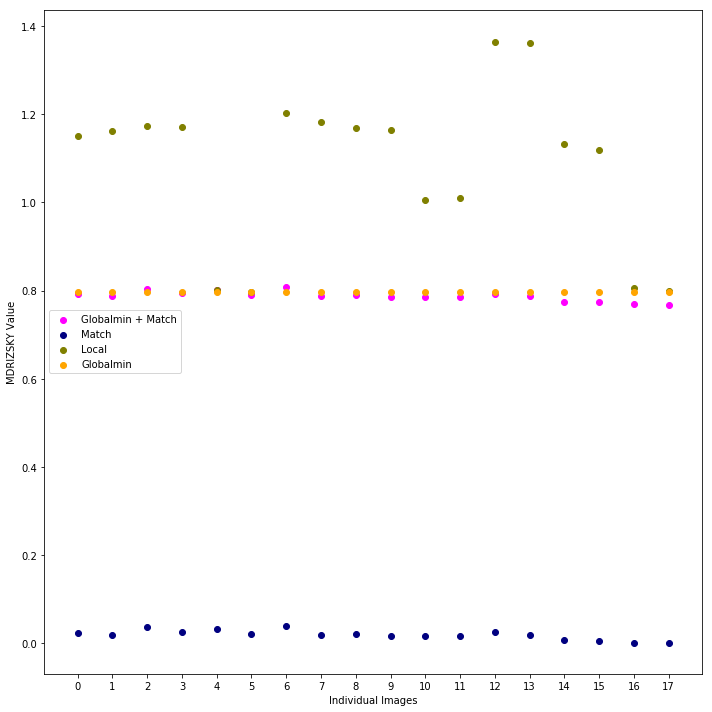

In [13]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

#Plotting code: 
fig = plt.figure(figsize=[10,10])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color = 'orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc="center left")
plt.xticks(index)
plt.tight_layout()

## 5. Display the full 'matched' mosaic 

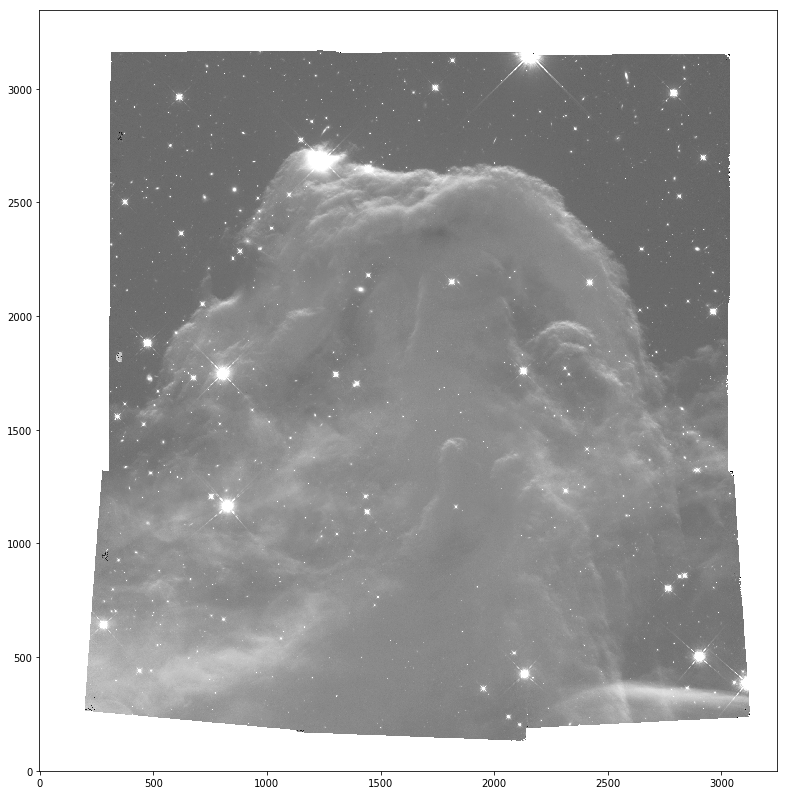

In [14]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=-0.4, vmax=3, cmap='Greys_r', origin='lower')

# About this Notebook

    Author: C. Martlin, STScI WFC3 Team  
    Updated: December, 14 2018